In [2]:
!pip install torch torchvision torchaudio
!pip install diffusers transformers
!pip install pillow

In [4]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline
from PIL import Image
import numpy as np
from IPython.display import display

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
modelid = "CompVis/stable-diffusion-v1-4"
pipe = StableDiffusionPipeline.from_pretrained(modelid, revision="fp16", torch_dtype=torch.float16)
pipe.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_loading_utils.py:219: FutureWarning: You are loading the variant fp16 from CompVis/stable-diffusion-v1-4 via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
safety_checker/model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

(…)kpoints/scheduler_config-checkpoint.json:   0%|          | 0.00/209 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/307 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.63k [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/608M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/572 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/788 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/2880f2ca379f41b0226444936bb7a6766a227587/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v1-4/snapshots/2880f2ca379f41b0226444936bb7a67

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.30.3",
  "_name_or_path": "CompVis/stable-diffusion-v1-4",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [7]:
def dummy_safety_checker(images, clip_input):
    return images, [False] * len(images)

pipe.safety_checker = dummy_safety_checker

In [8]:
def is_nsfw_prompt(prompt_text):
    nsfw_keywords = ["nude", "nudity", "sex", "porn", "explicit", "nsfw"]
    return any(keyword in prompt_text.lower() for keyword in nsfw_keywords)

In [9]:
def normalize_image(image):
    image = np.nan_to_num(image, nan=0.0, posinf=1.0, neginf=0.0)
    image = np.clip(image, 0, 1)
    image = (image * 255).round().astype(np.uint8)
    return image

In [10]:
def generate_image(prompt_text):
    if is_nsfw_prompt(prompt_text):
        print("NSFW content detected. Please try again.")
        return

    try:
        with autocast(device):
            result = pipe(prompt_text, guidance_scale=7.5)

        if 'images' in result:
            image = result['images'][0]
            pil_image = Image.fromarray(np.array(image))
            display(pil_image)
            pil_image.save('generatedimage.jpg')
        else:
            print("No images generated. Please try again.")
    except Exception as e:
        print(f"Error generating image: {e}")

  0%|          | 0/50 [00:00<?, ?it/s]

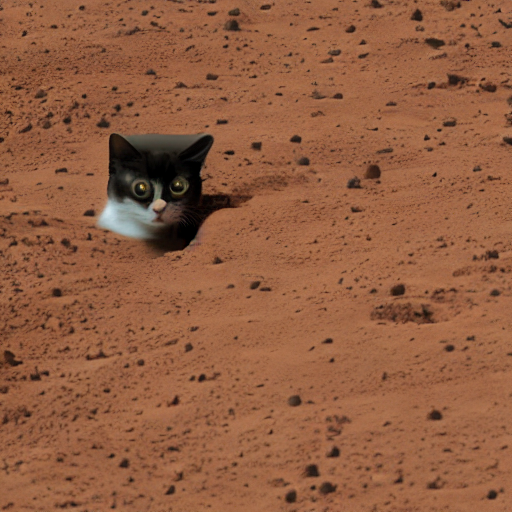

In [11]:
prompt_text = "cat on mars"
generate_image(prompt_text)